In [1]:
import numpy as np
import cv2
from numba import cuda
import math
import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display


# Differential Box-Counting: Measuring Fractal Dimension of Surfaces

**Part 1: Foundations → Chapter 2: Mathematical Foundations of Fractals**

---

## Overview

This notebook implements the **Differential Box-Counting (DBC)** algorithm, an extension of the standard box-counting method designed to estimate the fractal dimension of grayscale images and 2D/3D surfaces. Unlike traditional box-counting which works on binary sets, DBC treats grayscale intensity as a third dimension, making it ideal for analyzing terrain data, medical images, and fractal surfaces.

## Learning Objectives

By the end of this notebook, you will be able to:

1. Understand the relationship between standard box-counting and differential box-counting
2. Implement the DBC algorithm on grayscale images and height fields
3. Generate synthetic fractional Brownian surfaces with known fractal dimensions
4. Validate DBC results against theoretical expectations
5. Interpret log-log plots and extract fractal dimensions from power-law relationships

## Theoretical Background

### Box-Counting Dimension

For a set $S \subset \mathbb{R}^n$, the **box-counting dimension** is defined as:

$$
D_B = \lim_{\varepsilon \to 0} \frac{\log N(\varepsilon)}{\log(1/\varepsilon)}
$$

where $N(\varepsilon)$ is the number of boxes of side length $\varepsilon$ needed to cover the set $S$.

### Differential Box-Counting Method

For a grayscale image $I(x,y)$ where intensity represents height, the DBC algorithm:

1. **Partition the image** into non-overlapping $s \times s$ pixel blocks
2. **Scale intensity to 3D space**: Map intensity values to a third dimension with height $h = s \cdot G/M$ where $G$ is the maximum gray level and $M$ is image size
3. **Count boxes in each column**: For each $(i,j)$ block, compute:
   $$
   n_r(i,j) = \left\lceil \frac{\max(I) - \min(I) + 1}{h} \right\rceil
   $$
   where $\max(I)$ and $\min(I)$ are the maximum and minimum intensities in that block
4. **Sum contributions**: $N_r = \sum_{i,j} n_r(i,j)$
5. **Repeat for multiple scales** $r = 2, 4, 8, 16, \ldots$
6. **Linear regression**: Fit $\log N_r$ vs $\log(1/r)$ to extract slope $D$

### Fractional Brownian Surfaces

A **fractional Brownian surface** (fBs) is the 2D extension of fractional Brownian motion. It is characterized by the **Hurst exponent** $H \in (0,1)$:

$$
Z(\lambda x, \lambda y) \stackrel{d}{=} \lambda^H Z(x,y)
$$

The fractal dimension of an fBs relates to the Hurst exponent as:

$$
D = 3 - H
$$

**Interpretation:**
- $H = 0.2$: Very rough surface, $D \approx 2.8$ (fills space almost completely)
- $H = 0.5$: Standard Brownian surface, $D = 2.5$ (intermediate roughness)
- $H = 0.8$: Smooth surface, $D = 2.2$ (close to a smooth plane)

### Power Law Scaling

The fundamental relationship is:

$$
N(\varepsilon) = C \cdot \varepsilon^{-D}
$$

Taking logarithms:

$$
\log N(\varepsilon) = \log C - D \log \varepsilon = \log C + D \log(1/\varepsilon)
$$

The fractal dimension $D$ is the slope of the line in log-log space.

## Implementation Notes

- **CUDA Acceleration**: Uses GPU if available via Numba CUDA, otherwise falls back to CPU implementation
- **Demo Mode**: Generates synthetic fractional Brownian surfaces with known theoretical dimensions for validation
- **File Support**: Loads images (.png, .jpg, .tif) or numerical data (.txt, .csv)
- **Automatic Scaling**: Chooses appropriate box sizes based on image dimensions

## References

1. **Sarkar, N., & Chaudhuri, B. B. (1994).** "An efficient differential box-counting approach to compute fractal dimension of image." *IEEE Transactions on Systems, Man, and Cybernetics*, 24(1), 115-120.

2. **Mandelbrot, B. B., & Van Ness, J. W. (1968).** "Fractional Brownian motions, fractional noises and applications." *SIAM Review*, 10(4), 422-437.

3. **Falconer, K. (2014).** *Fractal Geometry: Mathematical Foundations and Applications* (3rd ed.). Wiley.

4. **Voss, R. F. (1985).** "Random Fractal Forgeries." In *Fundamental Algorithms for Computer Graphics* (pp. 805-835). Springer.

---

## Requirements

```python
# Core dependencies
numpy >= 1.20.0
matplotlib >= 3.5.0
numba >= 0.55.0  # For JIT compilation and optional CUDA

# Image processing (optional)
opencv-python  # Preferred for image loading
Pillow  # Fallback if OpenCV not available
```

Install with:
```bash
pip install numpy matplotlib numba opencv-python
# Or use the provided environment.yml:
mamba env create -f environment.yml
```

---

In [2]:
def generate_fbm_surface(size=512, H=0.7):
    """
    Generate a fractional Brownian surface for testing DBC algorithm.
    
    Parameters:
    -----------
    size : int
        Size of the square surface (size x size pixels)
    H : float
        Hurst exponent (0 < H < 1). Controls roughness:
        - H ~ 0.2: Very rough surface (high fractal dimension ~2.8)
        - H ~ 0.5: Brownian surface (fractal dimension ~2.5)
        - H ~ 0.8: Smooth surface (low fractal dimension ~2.2)
    
    Returns:
    --------
    surface : ndarray
        2D array normalized to [0, 255] as uint8
    max_intensity : int
        Maximum intensity value (255)
    """
    print(f"Generating {size}x{size} fractional Brownian surface with H={H}...")
    
    # Use spectral synthesis method
    freq_grid = np.fft.fftfreq(size)
    fx, fy = np.meshgrid(freq_grid, freq_grid)
    f = np.sqrt(fx**2 + fy**2)
    f[0, 0] = 1  # Avoid division by zero

    # Power spectrum: S(f) ∝ f^(-2H-2)
    # This creates a self-affine surface with Hurst exponent H
    power_spectrum = f ** (-(2*H + 2))
    power_spectrum[0, 0] = 0

    # Generate random phases
    phases = 2 * np.pi * np.random.rand(size, size)

    # Create complex Fourier coefficients
    amplitude = np.sqrt(power_spectrum / 2)
    fourier_coef = amplitude * np.exp(1j * phases)

    # Inverse FFT to get the surface
    surface = np.fft.ifft2(fourier_coef).real

    # Normalize to [0, 255]
    surface = (surface - surface.min()) / (surface.max() - surface.min()) * 255
    
    print(f"✓ Generated surface with expected fractal dimension ≈ {3-H:.2f}")
    print(f"  (Theoretical relationship: D = 3 - H for fBm surfaces)")
    
    return surface.astype(np.uint8), 255

In [3]:
import os

print("=" * 60)
print("Differential Box-Counting (DBC) Fractal Dimension Estimator")
print("=" * 60)
print("\nOptions:")
print("1. Load a file (.png, .jpg, .jpeg, .tif, .txt, .csv)")
print("2. Use demo data (generated fractional Brownian surface)")
print()

choice = input("Enter your choice (1 or 2): ").strip()

if choice == '2':
    # Use demo data
    print("\n--- Demo Mode ---")
    H_values = [0.3, 0.5, 0.7]
    print(f"\nAvailable Hurst exponents (H): {H_values}")
    print("  H=0.3 → very rough (expected D≈2.7)")
    print("  H=0.5 → Brownian (expected D≈2.5)")  
    print("  H=0.7 → smooth (expected D≈2.3)")
    
    H_choice = input(f"\nSelect Hurst exponent ({'/'.join(map(str, H_values))}), or press Enter for 0.7: ").strip()
    H = float(H_choice) if H_choice else 0.7
    
    img, max_intensity = generate_fbm_surface(size=512, H=H)
    file_path = f"demo_fbm_H{H}.surface"
    print(f"\n✓ Demo data loaded successfully!")
else:
    # Prompt the user for the file path
    file_path = input("\nPlease enter the file path (.png, .jpg, .jpeg, .tif, .txt, .csv): ")

    # Check if the file exists
    if not os.path.isfile(file_path):
        print("File not found. Please check the path and try again.")
        raise FileNotFoundError(f"File not found: {file_path}")
    else:
        # File will be loaded in the next cell
        _, file_extension = os.path.splitext(file_path)
        file_extension = file_extension.lower()
        print(f"✓ File path accepted: {file_path}")

Differential Box-Counting (DBC) Fractal Dimension Estimator

Options:
1. Load a file (.png, .jpg, .jpeg, .tif, .txt, .csv)
2. Use demo data (generated fractional Brownian surface)



Enter your choice (1 or 2):  2



--- Demo Mode ---

Available Hurst exponents (H): [0.3, 0.5, 0.7]
  H=0.3 → very rough (expected D≈2.7)
  H=0.5 → Brownian (expected D≈2.5)
  H=0.7 → smooth (expected D≈2.3)



Select Hurst exponent (0.3/0.5/0.7), or press Enter for 0.7:  0.5


Generating 512x512 fractional Brownian surface with H=0.5...
✓ Generated surface with expected fractal dimension ≈ 2.50
  (Theoretical relationship: D = 3 - H for fBm surfaces)

✓ Demo data loaded successfully!


In [4]:
def load_image_file(file_path):
    import cv2
    # Load the image in unchanged mode to preserve bit depth
    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError("The file is not a valid image or is corrupted.")
    else:
        # Convert to grayscale if it's a color image
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Check data type and normalize accordingly
        if img.dtype == np.uint16:
            print("16-bit image detected.")
            max_intensity = 65535
        elif img.dtype == np.uint8:
            print("8-bit image detected.")
            max_intensity = 255
        else:
            print(f"{img.dtype} image detected.")
            max_intensity = img.max()
        
        # Normalize the image to the range [0, max_intensity]
        img = cv2.normalize(img, None, 0, max_intensity, cv2.NORM_MINMAX).astype(img.dtype)
        
        return img, max_intensity


In [5]:
def load_large_float_file(file_path):
    import numpy as np

    # Determine the delimiter based on the file extension
    delimiter = ',' if file_path.endswith('.csv') else None  # None means any whitespace

    # Get the file size
    file_size = os.path.getsize(file_path)
    print(f"File size: {file_size / (1024 ** 3):.2f} GB")

    # Read the first line to check for header and estimate columns
    with open(file_path, 'r') as f:
        first_line = f.readline()
        # Try to parse the first line as floats
        try:
            first_values = [float(val) for val in first_line.strip().split(delimiter)]
            header = False
            num_cols = len(first_values)
            print("No header detected.")
        except ValueError:
            # First line is not numeric, assume it's a header
            header = True
            print("Header detected. Skipping the header line.")
            # Read the next line to get number of columns
            second_line = f.readline()
            first_values = [float(val) for val in second_line.strip().split(delimiter)]
            num_cols = len(first_values)
        # Close the file to reset the pointer
        f.close()

    # Read the data into a list of arrays
    data_list = []
    chunk_size = 10 ** 6  # Adjust based on available memory
    total_rows = 0
    max_value = -np.inf
    min_value = np.inf

    print("Reading the data in chunks...")
    with open(file_path, 'r') as f:
        if header:
            next(f)  # Skip the header line
        for i, line in enumerate(f):
            values = line.strip().split(delimiter)
            try:
                values = [float(val) for val in values]
            except ValueError:
                print(f"Non-numeric data found on line {i+2 if header else i+1}. Skipping this line.")
                continue  # Skip lines with non-numeric data
            data_list.append(values)
            if len(data_list) >= chunk_size:
                chunk_array = np.array(data_list, dtype=np.float32)
                max_value = max(max_value, np.nanmax(chunk_array))
                min_value = min(min_value, np.nanmin(chunk_array))
                total_rows += chunk_array.shape[0]
                data_list = []  # Reset the list for the next chunk

        # Handle the last chunk
        if data_list:
            chunk_array = np.array(data_list, dtype=np.float32)
            max_value = max(max_value, np.nanmax(chunk_array))
            min_value = min(min_value, np.nanmin(chunk_array))
            total_rows += chunk_array.shape[0]

    print(f"Total rows: {total_rows}, Columns per row: {num_cols}")
    print(f"Data range: min={min_value}, max={max_value}")

    # Concatenate all chunks to form the full array
    # Note: For very large datasets, consider processing without concatenation
    img = np.array(data_list, dtype=np.float32)
    max_intensity = max_value

    return img, max_intensity



In [6]:
from numba import cuda

# CUDA kernel for computing N(s) for a given scale s
@cuda.jit
def compute_ns(img, s, Ns, max_intensity):
    y, x = cuda.grid(2)
    rows, cols = img.shape
    nx = (cols + s - 1) // s  # Number of boxes along x
    ny = (rows + s - 1) // s  # Number of boxes along y

    if x < nx and y < ny:
        z_min = max_intensity
        z_max = 0
        for i in range(s):
            for j in range(s):
                xi = x * s + i
                yj = y * s + j
                if xi < cols and yj < rows:
                    val = img[yj, xi]
                    if val < z_min:
                        z_min = val
                    if val > z_max:
                        z_max = val
        n = math.ceil((z_max - z_min) / s) + 1
        Ns[y, x] = n


In [7]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Enable interactive plotting - Changed from 'widget' to 'inline' for compatibility
%matplotlib inline

# Prompt the user for the file path
file_path = input("Please enter the file path (.png, .jpg, .jpeg, .tif, .txt, .csv): ")

# Check if the file exists
if not os.path.isfile(file_path):
    print("File not found. Please check the path and try again.")
else:
    # Determine the file extension
    _, file_extension = os.path.splitext(file_path)
    file_extension = file_extension.lower()
    
    # Function to load image files
    def load_image_file(file_path):
        try:
            import cv2
            CV2_AVAILABLE = True
        except ImportError:
            CV2_AVAILABLE = False
            print("OpenCV not installed. Install with: pip install opencv-python")
            print("Falling back to PIL for image loading.")
            from PIL import Image
        
        if CV2_AVAILABLE:
            # Load the image in unchanged mode to preserve bit depth
            img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                raise ValueError("The file is not a valid image or is corrupted.")
            else:
                # Convert to grayscale if it's a color image
                if len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
                # Check data type and normalize accordingly
                if img.dtype == np.uint16:
                    print("16-bit image detected.")
                    max_intensity = 65535
                elif img.dtype == np.uint8:
                    print("8-bit image detected.")
                    max_intensity = 255
                else:
                    print(f"{img.dtype} image detected.")
                    max_intensity = img.max()
                
                # Normalize the image to the range [0, max_intensity]
                img = cv2.normalize(img, None, 0, max_intensity, cv2.NORM_MINMAX).astype(img.dtype)
        else:
            # Fallback to PIL
            img_pil = Image.open(file_path).convert('L')  # Convert to grayscale
            img = np.array(img_pil)
            max_intensity = 255 if img.dtype == np.uint8 else 65535
        
        return img, max_intensity
    
    # Function to load large float files with header handling
    def load_large_float_file(file_path):
        import numpy as np

        # Determine the delimiter based on the file extension
        delimiter = ',' if file_path.endswith('.csv') else None  # None means any whitespace

        # Get the file size
        file_size = os.path.getsize(file_path)
        print(f"File size: {file_size / (1024 ** 3):.2f} GB")

        # Read the first line to check for header and estimate columns
        with open(file_path, 'r') as f:
            first_line = f.readline()
            # Try to parse the first line as floats
            try:
                first_values = [float(val) for val in first_line.strip().split(delimiter)]
                header = False
                num_cols = len(first_values)
                print("No header detected.")
            except ValueError:
                # First line is not numeric, assume it's a header
                header = True
                print("Header detected. Skipping the header line.")
                # Read the next line to get number of columns
                second_line = f.readline()
                first_values = [float(val) for val in second_line.strip().split(delimiter)]
                num_cols = len(first_values)
            # Close the file to reset the pointer
            f.close()

        # Read the data into a list of arrays
        data_list = []
        chunk_size = 10 ** 6  # Adjust based on available memory
        total_rows = 0
        max_value = -np.inf
        min_value = np.inf

        print("Reading the data in chunks...")
        with open(file_path, 'r') as f:
            if header:
                next(f)  # Skip the header line
            for i, line in enumerate(f):
                values = line.strip().split(delimiter)
                try:
                    values = [float(val) for val in values]
                except ValueError:
                    print(f"Non-numeric data found on line {i+2 if header else i+1}. Skipping this line.")
                    continue  # Skip lines with non-numeric data
                data_list.append(values)
                if len(data_list) >= chunk_size:
                    chunk_array = np.array(data_list, dtype=np.float32)
                    max_value = max(max_value, np.nanmax(chunk_array))
                    min_value = min(min_value, np.nanmin(chunk_array))
                    total_rows += chunk_array.shape[0]
                    data_list = []  # Reset the list for the next chunk

            # Handle the last chunk
            if data_list:
                chunk_array = np.array(data_list, dtype=np.float32)
                max_value = max(max_value, np.nanmax(chunk_array))
                min_value = min(min_value, np.nanmin(chunk_array))
                total_rows += chunk_array.shape[0]

        print(f"Total rows: {total_rows}, Columns per row: {num_cols}")
        print(f"Data range: min={min_value}, max={max_value}")

        # Concatenate all chunks to form the full array
        img = np.array(data_list, dtype=np.float32)
        max_intensity = max_value

        return img, max_intensity
    
    # Main code block
    try:
        if file_extension in ['.png', '.jpg', '.jpeg', '.tif']:
            img, max_intensity = load_image_file(file_path)
        elif file_extension in ['.txt', '.csv']:
            img, max_intensity = load_large_float_file(file_path)
        else:
            raise ValueError("Unsupported file type.")
        
        image_name = os.path.basename(file_path)
        print(f"Loaded File: {image_name}")
        
        # Display the image
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(img, cmap='gray', origin='upper')
        ax.set_title('Loaded Data')
        ax.axis('on')  # Show axes to display coordinates
        plt.colorbar(im, ax=ax)
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

Please enter the file path (.png, .jpg, .jpeg, .tif, .txt, .csv):  ./


File not found. Please check the path and try again.


In [8]:
try:
    if file_extension in ['.png', '.jpg', '.jpeg', '.tif']:
        img, max_intensity = load_image_file(file_path)
    elif file_extension in ['.txt', '.csv']:
        img, max_intensity = load_large_float_file(file_path)
    else:
        raise ValueError("Unsupported file type.")
    
    image_name = os.path.basename(file_path)
    print(f"Loaded File: {image_name}")
    plt.imshow(img, cmap='gray')
    plt.title('Loaded Data')
    plt.axis('on')
    plt.show()
except Exception as e:
    print(f"Error: {e}")


Error: name 'file_extension' is not defined


In [9]:
# Check CUDA availability and provide CPU fallback
try:
    from numba import cuda
    CUDA_AVAILABLE = cuda.is_available()
    if CUDA_AVAILABLE:
        print("✓ CUDA available - using GPU acceleration")
        # CUDA kernel for computing N(s) for a given scale s
        @cuda.jit
        def compute_ns_cuda(img, s, Ns, max_intensity):
            y, x = cuda.grid(2)
            rows, cols = img.shape
            nx = (cols + s - 1) // s  # Number of boxes along x
            ny = (rows + s - 1) // s  # Number of boxes along y

            if x < nx and y < ny:
                z_min = max_intensity
                z_max = 0.0
                for i in range(s):
                    for j in range(s):
                        xi = x * s + i
                        yj = y * s + j
                        if xi < cols and yj < rows:
                            val = img[yj, xi]
                            if val < z_min:
                                z_min = val
                            if val > z_max:
                                z_max = val
                n = math.ceil((z_max - z_min) / s) + 1
                Ns[y, x] = n
    else:
        print("⚠ CUDA not available - using CPU implementation")
except ImportError:
    CUDA_AVAILABLE = False
    print("⚠ Numba CUDA not installed - using CPU implementation")

# CPU fallback using Numba JIT
if not CUDA_AVAILABLE:
    from numba import njit
    
    @njit
    def compute_ns_cpu(img, s, max_intensity):
        """CPU version of DBC computation."""
        rows, cols = img.shape
        nx = (cols + s - 1) // s
        ny = (rows + s - 1) // s
        Ns = np.zeros((ny, nx), dtype=np.int32)

        for y in range(ny):
            for x in range(nx):
                z_min = max_intensity
                z_max = 0.0
                for i in range(s):
                    for j in range(s):
                        xi = x * s + i
                        yj = y * s + j
                        if xi < cols and yj < rows:
                            val = img[yj, xi]
                            z_min = min(z_min, val)
                            z_max = max(z_max, val)
                Ns[y, x] = int(np.ceil((z_max - z_min) / s)) + 1
        return Ns

✓ CUDA available - using GPU acceleration


In [10]:
def compute_fractal_dimension(img, scales, max_intensity):
    """
    Compute fractal dimension using Differential Box-Counting method.
    Automatically uses CUDA if available, otherwise falls back to CPU.
    """
    Ns_list = []
    inv_scales = []
    
    for s in scales:
        nx = (img.shape[1] + s - 1) // s
        ny = (img.shape[0] + s - 1) // s
        
        if CUDA_AVAILABLE:
            # Use CUDA implementation
            Ns = np.zeros((ny, nx), dtype=np.int32)
            
            # Prepare the image and Ns arrays for CUDA
            img_device = cuda.to_device(img)
            Ns_device = cuda.to_device(Ns)
            
            # CUDA grid and block dimensions
            threadsperblock = (16, 16)
            blockspergrid_x = (nx + threadsperblock[1] - 1) // threadsperblock[1]
            blockspergrid_y = (ny + threadsperblock[0] - 1) // threadsperblock[0]
            blockspergrid = (blockspergrid_y, blockspergrid_x)
            
            # Launch CUDA kernel
            compute_ns_cuda[blockspergrid, threadsperblock](img_device, s, Ns_device, max_intensity)
            cuda.synchronize()
            
            # Copy the result back to host
            Ns = Ns_device.copy_to_host()
        else:
            # Use CPU implementation
            Ns = compute_ns_cpu(img, s, max_intensity)
        
        N = Ns.sum()
        Ns_list.append(N)
        inv_scales.append(1/s)
        
        print(f"Scale: {s:4d}, N(s): {N:12d}")
        
    # Linear fit to estimate the fractal dimension
    log_Ns = np.log(Ns_list)
    log_inv_scales = np.log(inv_scales)
    coeffs = np.polyfit(log_inv_scales, log_Ns, 1)
    fractal_dimension = coeffs[0]
    
    return fractal_dimension, log_inv_scales, log_Ns

In [11]:
if 'img' in globals():
    # Define scales (adjust based on image size)
    min_scale = 2
    max_scale = min(img.shape) // 4  # Maximum scale to consider
    num_scales = 5  # Number of scales to evaluate
    scales = [int(min_scale * (2 ** i)) for i in range(num_scales) if min_scale * (2 ** i) <= max_scale]
    
    if not scales:
        scales = [2, 4]  # Fallback scales if image is too small
    
    print(f"Scales to be used: {scales}")
    
    fractal_dimension, log_inv_scales, log_Ns = compute_fractal_dimension(img, scales, max_intensity)
    print(f"\nEstimated Fractal Dimension: {fractal_dimension:.4f}")
else:
    print("Image not loaded. Please provide a valid image path.")



Scales to be used: [2, 4, 8, 16, 32]
Scale:    2, N(s):       350205
Scale:    4, N(s):       102678
Scale:    8, N(s):        23841
Scale:   16, N(s):         5147
Scale:   32, N(s):         1064

Estimated Fractal Dimension: 2.1043


/opt/conda/envs/fractal-foundations-gpu/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/opt/conda/envs/fractal-foundations-gpu/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/opt/conda/envs/fractal-foundations-gpu/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/opt/conda/envs/fractal-foundations-gpu/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


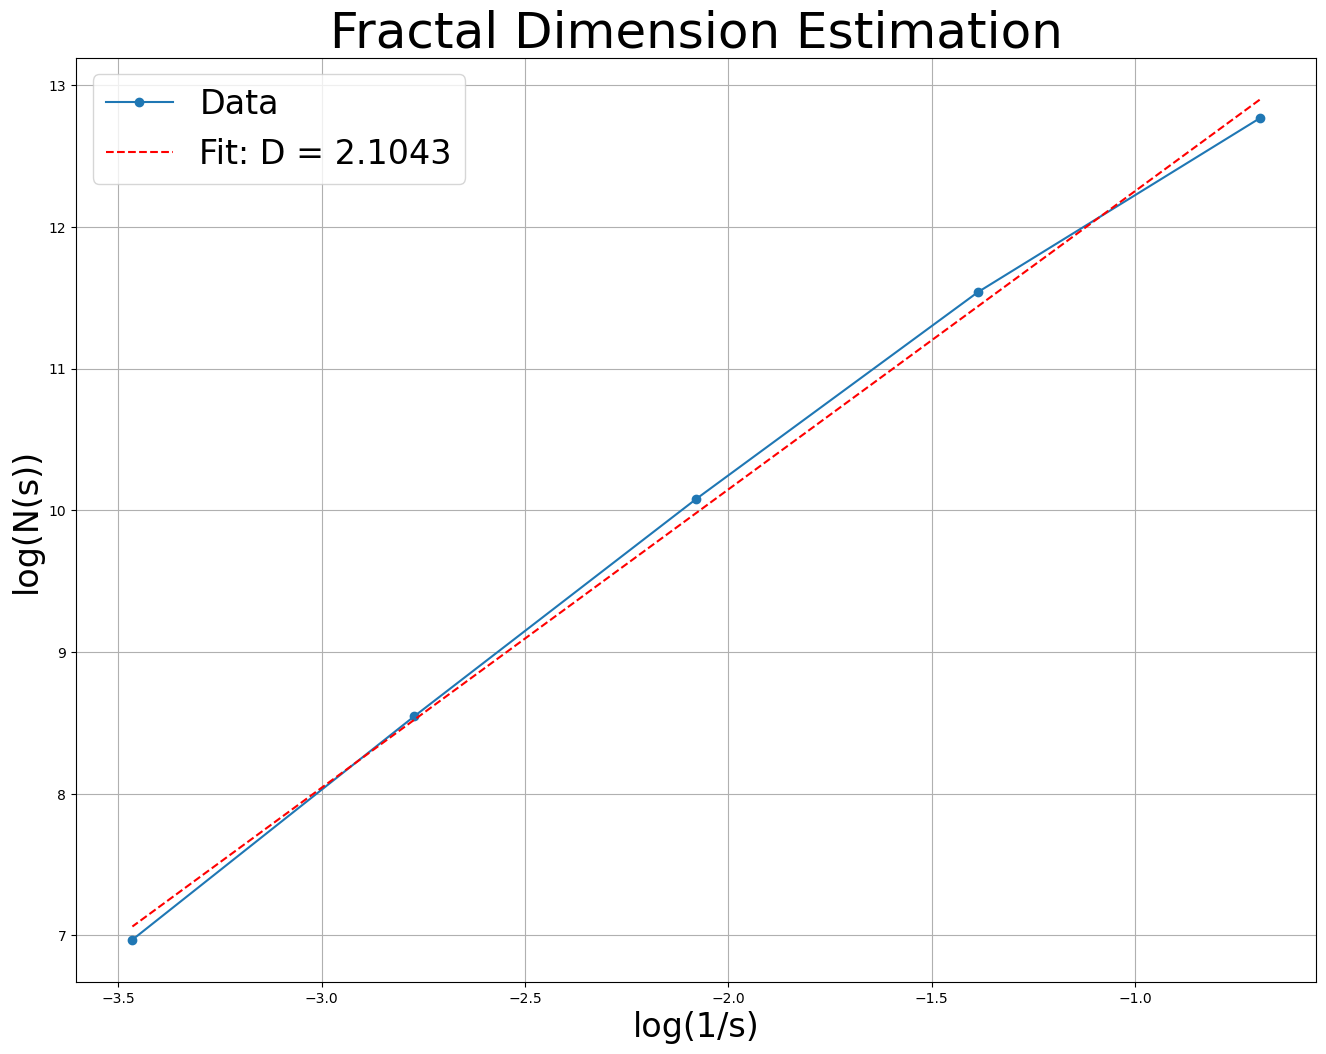

In [12]:
if 'img' in globals():
    # Plotting the log-log plot
    plt.figure(figsize=(16, 12))
    plt.plot(log_inv_scales, log_Ns, 'o-', label='Data')
    # Plot the fitted line
    coeffs = np.polyfit(log_inv_scales, log_Ns, 1)
    plt.plot(log_inv_scales, np.polyval(coeffs, log_inv_scales), 'r--', label=f'Fit: D = {coeffs[0]:.4f}')
    plt.xlabel('log(1/s)', fontsize=24)
    plt.ylabel('log(N(s))', fontsize=24)
    plt.title('Fractal Dimension Estimation', fontsize=36)
    plt.legend(fontsize=24)
    plt.grid(True)
    plt.show()
else:
    print("Image not loaded. Please provide a valid image path.")

